#                                                        Analysis of City Similarities

#                        Introduction
## The top 10 largest US cities by populations are: 
### 1. New York City, NY
### 2. Los Angeles, CA
### 3. Chicago, IL
### 4. Houston, TX
### 5. Phoenix, AZ
### 6. Philadelphia, PA
### 7. San Antonio, TX
### 8. San Diego, CA
### 9. Dallas, TX
### 10. San Jose, CA

## I'm curious about the similarity among them and going to cluster them using venue-based similarity measurement.
## It will be useful for movers from those 10 cities to find the one that they are already familar with and like to live.

# Data Description
## I'm going to use the following data for my research:
### - The geograpical coordinate of the 10 cities
### - The top 100 venues that are within a radius of 500 meters of each city.

In [ ]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation


!pip install geopy
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize


! pip install folium==0.5.0
import folium # plotting library

print('Folium installed')
print('Libraries imported.')

In [2]:
# The code was removed by Watson Studio for sharing.

In [3]:
df_Top10=pd.DataFrame({'Cities':['New York City, NY','Los Angeles, CA','Chicago, IL','Houston, TX','Phoenix, AZ','Philadelphia, PA','San Antonio, TX','San Diego, CA','Dallas, TX','San Jose, CA']})

In [5]:
df_Top10

,Cities
0,"New York City, NY"
1,"Los Angeles, CA"
2,"Chicago, IL"
3,"Houston, TX"
4,"Phoenix, AZ"
5,"Philadelphia, PA"
6,"San Antonio, TX"
7,"San Diego, CA"
8,"Dallas, TX"
9,"San Jose, CA"


# Get the geograpical coordinate of the 10 cities

In [4]:
def get_LL(address):
    geolocator = Nominatim(user_agent="Top10")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude, longitude

In [5]:
df_Top10['Latitude'],df_Top10['Longitude']=zip(*df_Top10['Cities'].apply(get_LL))

In [6]:
df_Top10

,Cities,Latitude,Longitude
0,"New York City, NY",40.712728,-74.006015
1,"Los Angeles, CA",34.053691,-118.242766
2,"Chicago, IL",41.875562,-87.624421
3,"Houston, TX",29.758938,-95.367697
4,"Phoenix, AZ",33.448437,-112.074142
5,"Philadelphia, PA",39.952724,-75.163526
6,"San Antonio, TX",29.424600,-98.495141
7,"San Diego, CA",32.717420,-117.162773
8,"Dallas, TX",32.776272,-96.796856
9,"San Jose, CA",37.336191,-121.890583


# Get the top 100 venues for each city

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Cities', 
                  'Latitude', 
                  'Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
    

In [8]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [9]:
names,lats,longs=df_Top10['Cities'],df_Top10['Latitude'],df_Top10['Longitude']
Top10_venues=getNearbyVenues(names,lats,longs)

New York City, NY
Los Angeles, CA
Chicago, IL
Houston, TX
Phoenix, AZ
Philadelphia, PA
San Antonio, TX
San Diego, CA
Dallas, TX
San Jose, CA


In [10]:
Top10_venues

,Cities,Latitude,Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"New York City, NY",40.712728,-74.006015,The Bar Room at Temple Court,40.711448,-74.006802,Hotel Bar
1,"New York City, NY",40.712728,-74.006015,"The Beekman, A Thompson Hotel",40.711173,-74.006702,Hotel
2,"New York City, NY",40.712728,-74.006015,Alba Dry Cleaner & Tailor,40.711434,-74.006272,Laundry Service
3,"New York City, NY",40.712728,-74.006015,City Hall Park,40.711893,-74.007792,Park
4,"New York City, NY",40.712728,-74.006015,Gibney Dance Center Downtown,40.713923,-74.005661,Dance Studio
...,...,...,...,...,...,...,...
720,"San Jose, CA",37.336191,-121.890583,Circle-A,37.333573,-121.886063,Board Shop
721,"San Jose, CA",37.336191,-121.890583,M Lounge,37.334917,-121.888036,Asian Restaurant
722,"San Jose, CA",37.336191,-121.890583,71 Saint Peter Restaurant,37.336341,-121.893968,Modern European Restaurant
723,"San Jose, CA",37.336191,-121.890583,Chase Bank,37.335420,-121.887444,Bank


# Analyze Cities

In [ ]:
## one hot encoding
Top10_onehot = pd.get_dummies(Top10_venues[['Venue Category']], prefix="", prefix_sep="")

## add neighborhood column back to dataframe
Top10_onehot['Cities'] = Top10_venues['Cities']

# move neighborhood column to the first column
fixed_columns = [Top10_onehot.columns[-1]] + list(Top10_onehot.columns[:-1])
Top10_onehot = Top10_onehot[fixed_columns]

Top10_onehot.head()

In [66]:
Top10_grouped=Top10_onehot.groupby('Cities').mean().reset_index()

In [67]:
Top10_grouped

,Cities,Accessories Store,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Baby Store,...,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"Chicago, IL",0.000000,0.020000,0.00,0.01,0.00,0.02,0.02,0.02,0.00,...,0.000000,0.00,0.01,0.000000,0.01,0.000000,0.00,0.00,0.00,0.00
1,"Dallas, TX",0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00
2,"Houston, TX",0.000000,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000000,0.00,0.00,0.000000,0.00,0.023810,0.00,0.00,0.00,0.00
3,"Los Angeles, CA",0.000000,0.040000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000000,0.04,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00
4,"New York City, NY",0.000000,0.020000,0.01,0.00,0.00,0.00,0.00,0.01,0.01,...,0.000000,0.00,0.01,0.000000,0.00,0.000000,0.02,0.00,0.01,0.02
5,"Philadelphia, PA",0.000000,0.030000,0.00,0.00,0.00,0.01,0.01,0.01,0.00,...,0.000000,0.00,0.02,0.000000,0.00,0.010000,0.00,0.00,0.00,0.02
6,"Phoenix, AZ",0.000000,0.061538,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000000,0.00,0.00,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00
7,"San Antonio, TX",0.000000,0.036585,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000000,0.00,0.00,0.000000,0.00,0.012195,0.00,0.00,0.00,0.00
8,"San Diego, CA",0.010753,0.021505,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.010753,0.00,0.00,0.010753,0.00,0.010753,0.00,0.00,0.00,0.00
9,"San Jose, CA",0.000000,0.010000,0.00,0.00,0.01,0.01,0.00,0.02,0.00,...,0.000000,0.00,0.01,0.010000,0.00,0.000000,0.00,0.01,0.00,0.01


In [14]:
# The code was removed by Watson Studio for sharing.

In [19]:
#Save dataframe as csv file to storage
#project.save_data(data=Top10_venues.to_csv(index=False),file_name='Top10_venues.csv',overwrite=True)
#project.save_data(data=df_Top10.to_csv(index=False),file_name='Top10.csv',overwrite=True)
#table_PC=pd.read_csv(project.get_file('LL.csv'))

In [18]:
#project.save_data(data=Top10_grouped.to_csv(index=False),file_name='Top10_grouped.csv',overwrite=True)

In [21]:
featureset = Top10_grouped[Top10_grouped.columns[1:]]

In [22]:
featureset.head()

,Accessories Store,American Restaurant,Antique Shop,Arepa Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Baby Store,Bagel Shop,...,Turkish Restaurant,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0.0,0.02,0.00,0.01,0.0,0.02,0.02,0.02,0.00,0.00,...,0.0,0.00,0.01,0.0,0.01,0.00000,0.00,0.0,0.00,0.00
1,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,0.00,0.0,0.00,0.00000,0.00,0.0,0.00,0.00
2,0.0,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.0,0.00,0.00,0.0,0.00,0.02381,0.00,0.0,0.00,0.00
3,0.0,0.04,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,...,0.0,0.04,0.00,0.0,0.00,0.00000,0.00,0.0,0.00,0.00
4,0.0,0.02,0.01,0.00,0.0,0.00,0.00,0.01,0.01,0.01,...,0.0,0.00,0.01,0.0,0.00,0.00000,0.02,0.0,0.01,0.02


In [24]:
from sklearn.preprocessing import MinMaxScaler
x = featureset.values #returns a numpy array
min_max_scaler = MinMaxScaler()
feature_mtx = min_max_scaler.fit_transform(x)
feature_mtx

array([[0.        , 0.325     , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.5945122 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.34946237, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.1625    , 0.        , ..., 1.        , 0.        ,
        0.5       ]])

# Clustering using scikit-learn

In [25]:
from sklearn.metrics.pairwise import euclidean_distances
dist_matrix = euclidean_distances(feature_mtx,feature_mtx) 
print(dist_matrix)

[[0.         6.62143081 7.01568849 6.94613118 7.28790982 7.00826892
  6.766322   6.81591871 7.38220493 7.47607829]
 [6.62143081 0.         5.4770597  5.57104322 6.83643136 6.89654249
  5.55620315 5.5494677  6.3515684  6.77436307]
 [7.01568849 5.4770597  0.         5.90954501 7.04281916 7.1708909
  5.64239192 5.82455335 6.62976015 7.19127573]
 [6.94613118 5.57104322 5.90954501 0.         7.16076645 7.36250099
  5.90460616 6.01779286 6.82556201 7.14597911]
 [7.28790982 6.83643136 7.04281916 7.16076645 0.         7.64311534
  7.05975896 6.84329576 7.75868577 7.73601509]
 [7.00826892 6.89654249 7.1708909  7.36250099 7.64311534 0.
  7.05132235 6.68600688 7.13002067 7.36423344]
 [6.766322   5.55620315 5.64239192 5.90460616 7.05975896 7.05132235
  0.         5.42754634 6.75710371 6.69999832]
 [6.81591871 5.5494677  5.82455335 6.01779286 6.84329576 6.68600688
  5.42754634 0.         6.32054023 6.50305478]
 [7.38220493 6.3515684  6.62976015 6.82556201 7.75868577 7.13002067
  6.75710371 6.320540

# Which city is the most similar to New York?

In [47]:
dist_NY=list(dist_matrix[:,4])

In [68]:
df_NY=pd.DataFrame(columns=['Cities','Difference'])

In [69]:
df_NY['Cities']=Top10_grouped['Cities']

In [71]:
df_NY['Difference']=dist_NY

In [78]:
df_NY.sort_values('Difference',inplace=True)
df_NY

,Cities,Difference
4,"New York City, NY",0.000000
1,"Dallas, TX",6.836431
7,"San Antonio, TX",6.843296
2,"Houston, TX",7.042819
6,"Phoenix, AZ",7.059759
3,"Los Angeles, CA",7.160766
0,"Chicago, IL",7.287910
5,"Philadelphia, PA",7.643115
9,"San Jose, CA",7.736015
8,"San Diego, CA",7.758686


In [81]:
print('The most similar city to New York is: {}'.format(df_NY.iloc[1]['Cities']))

The most similar city to New York is: Dallas, TX


In [28]:
import pylab
import scipy.cluster.hierarchy

In [29]:
Z_using_dist_matrix = hierarchy.linkage(dist_matrix, 'complete')

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ipykernel/__main__.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  if __name__ == '__main__':


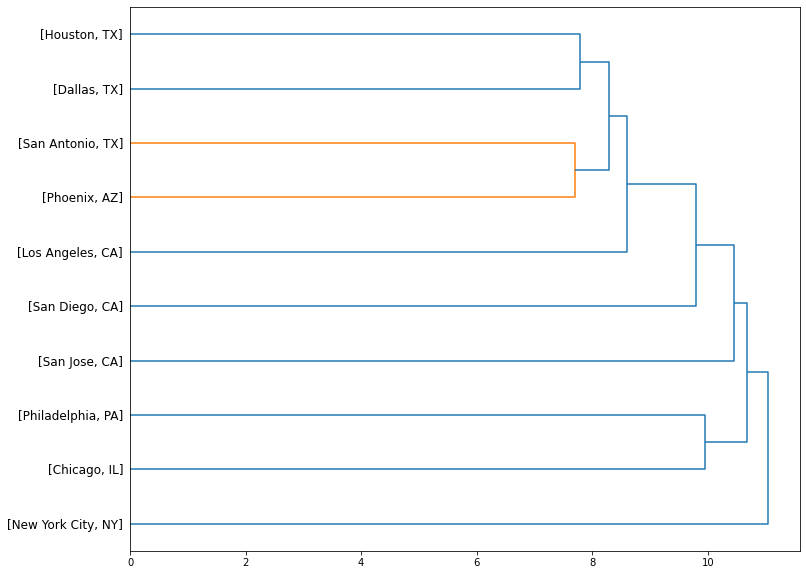

In [33]:
fig = pylab.figure(figsize=(12,10))
def llf(id):
    return '[%s]' % (Top10_grouped['Cities'][id] )
    
dendro = hierarchy.dendrogram(Z_using_dist_matrix,  leaf_label_func=llf, leaf_rotation=0, leaf_font_size =12, orientation = 'right')

# The above figure shows similarities among cities: for example, Houston TX and Dallas TX are quite similar.